In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pandas as pd
import re
%matplotlib widget

In [2]:
def read_tensors_aux(dir, tensor_names=None):
    """ recursively read tensors from a directory """
    tensors = {}
    for path in os.listdir(dir):
        if path.endswith('.pt'):
            key = path[:-3]
            if tensor_names is None or key in tensor_names:
                tensors[key] = torch.load(os.path.join(dir, path), map_location='cpu')
        elif os.path.isdir(os.path.join(dir, path)):
            key = path.split('_')[1] if path.startswith('timestep_') else path 
            tensors[key] = read_tensors_aux(os.path.join(dir, path), tensor_names=tensor_names)
        else:
            print(f"Skipping {path}, not a tensor or directory")
    return tensors

def read_tensors(dir, prompts=None, tensor_names=None):
    tensors = {}
    
    prompts = [ x for x in os.listdir(dir) if x in prompts ] if prompts is not None else [ x for x in os.listdir(dir) if os.path.isdir(os.path.join(dir, x)) ]
    
    for prompt in prompts:
        tensors[prompt] = read_tensors_aux(dir=os.path.join(dir, prompt), tensor_names=tensor_names)
        
    return tensors

In [3]:
def normalize_tensor(tensor):
    """
    Normalize a tensor to the range [0, 1].
    tensor: [f, h, w]
    """
    min_val = tensor.min()
    max_val = tensor.max()
    if max_val - min_val == 0:
        return tensor
    t = (tensor - min_val) / (max_val - min_val)
    # change type to float32 for better visualization
    return t.float()

def animate_tensor(tensor, title, save_mp4_filename=None, fps=2):
    """
    tensor: [f, h, w]
    title: title of the animation
    save_mp4_filename: if provided, saves the animation as an mp4 file with this name
    fps: frames per second for the animation
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    fig.tight_layout()

    ax.set_title(title, fontsize=20)
    im = ax.imshow(normalize_tensor(tensor[0,:,:]), animated=True, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    def updatefig(i):
        ax.set_title(title, fontsize=20)
        t = normalize_tensor(tensor[i, :, :])
        im.set_array(t)
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=tensor.shape[0], interval=50, blit=True)
    if save_mp4_filename:
        print(f'Saving tensor_visualizations/{save_mp4_filename}.mp4')
        ani.save(f'tensor_visualizations/{save_mp4_filename}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
           
    return ani

In [4]:
tensors = read_tensors('tensors')

In [10]:
mask_test = tensors[list(tensors.keys())[0]]  # List all available prompts

In [ ]:
for k in mask_test.keys():
    print(f"Key: {k}, Shape: {mask_test[k].shape}, Type: {mask_test[k].dtype}")

Key: video, Shape: torch.Size([50, 480, 854, 3]), Type: torch.float32
Key: original_mask, Shape: torch.Size([50, 480, 854]), Type: torch.float32
Key: mask, Shape: torch.Size([13, 60, 106]), Type: torch.float32


Saving tensor_visualizations/video_channel_0.mp4
Saving tensor_visualizations/video_channel_1.mp4
Saving tensor_visualizations/video_channel_2.mp4
Saving tensor_visualizations/original_mask.mp4
Saving tensor_visualizations/mask.mp4


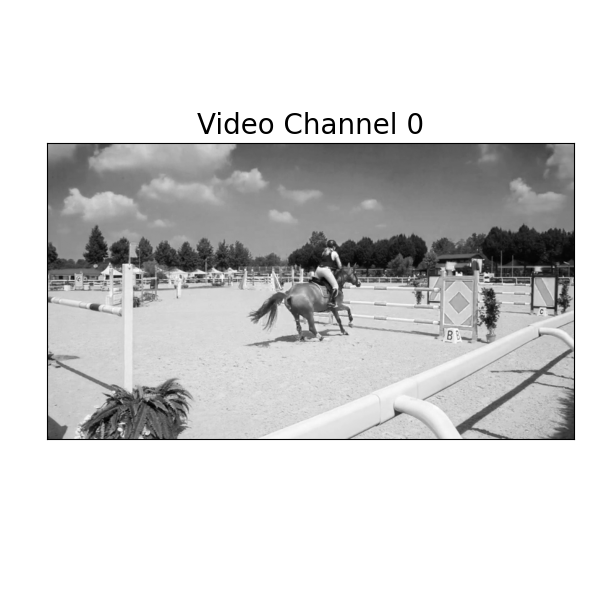

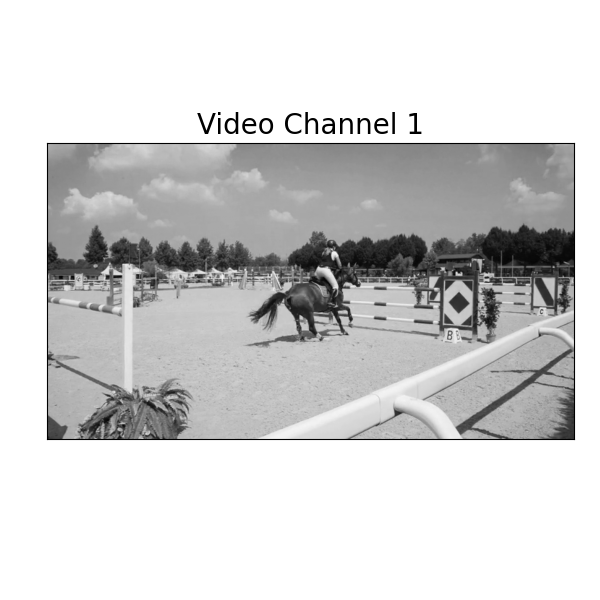

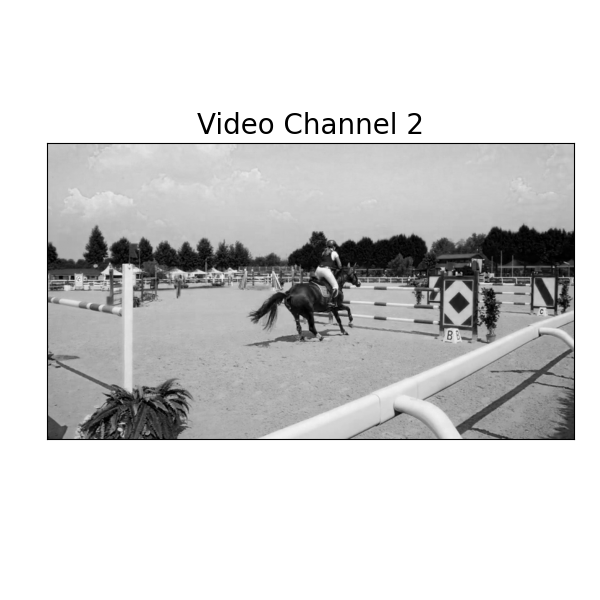

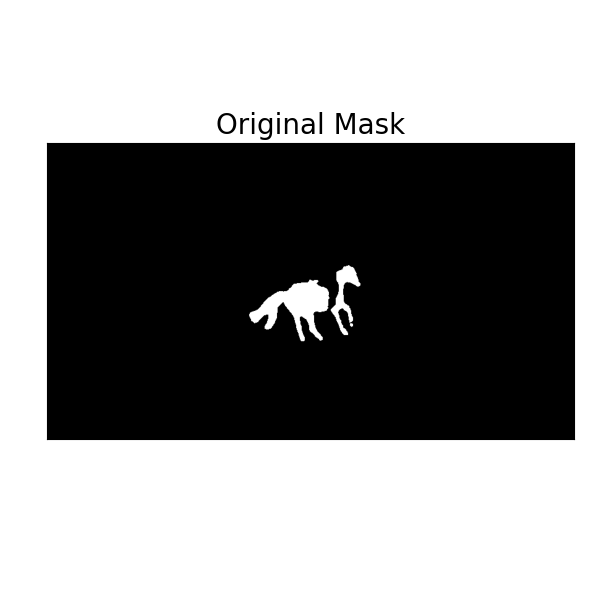

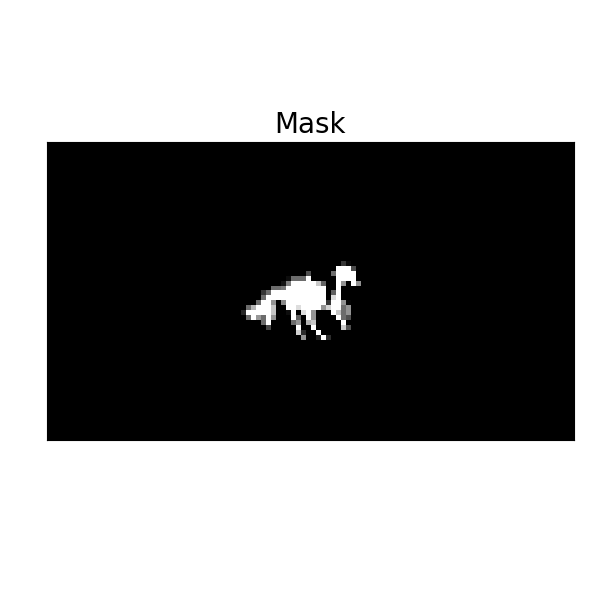

In [14]:
animate_tensor(mask_test['video'][:,:,:,0], title='Video Channel 0', save_mp4_filename='video_channel_0', fps=10)
animate_tensor(mask_test['video'][:,:,:,1], title='Video Channel 1', save_mp4_filename='video_channel_1', fps=10)
animate_tensor(mask_test['video'][:,:,:,2], title='Video Channel 2', save_mp4_filename='video_channel_2', fps=10)
animate_tensor(mask_test['original_mask'], title='Original Mask', save_mp4_filename='original_mask', fps=10)
animate_tensor(mask_test['mask'], title='Mask', save_mp4_filename='mask', fps=10)

In [ ]:
def animate_channels(tensor, channels=None, title="", save_mp4_filename=None, fps=2):
    """
    tensor: [f, h, w, c]
    title: title of the animation
    save_mp4_filename: if provided, saves the animation as an mp4 file with this name
    fps: frames per second for the animation
    """
    f, h, w, c = tensor.shape
    # create a figure with c subplots in a grid
    channels = channels if channels is not None else list(range(c))
    grid_len = int(len(channels)**0.5)
    assert float(grid_len) == len(channels) ** 0.5, "Number of channels must be a perfect square"
    fig, axs = plt.subplots(grid_len, grid_len, figsize=(10, 10), dpi=900)
    fig.tight_layout()

    fig.suptitle(title, fontsize=20)
    ims = [None] * len(channels)

    for j, ax in enumerate(axs.flat):
        if j < len(channels):
            ax.set_title(f'Channel {channels[j]}', fontsize=20)
            ims[j] = ax.imshow(tensor[0,:,:,channels[j]], animated=True, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

    def updatefig(i):
        for j, ax in enumerate(axs.flat):
            if j < len(channels):
                ax.set_title(title, fontsize=20)
                t = tensor[i, :, :, channels[j]]
                ims[j].set_array(t)
        return ims

    ani = animation.FuncAnimation(fig, updatefig, frames=tensor.shape[0], interval=50, blit=True)
    if save_mp4_filename:
        print(f'Saving tensor_visualizations/{save_mp4_filename}.mp4')
        ani.save(f'tensor_visualizations/{save_mp4_filename}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
           
    plt.show()
    return ani

In [58]:
# load tensor subject_mask from tensors
subject_mask = torch.load('tensors/subject_mask.pt', map_location='cpu')

In [59]:
subject_mask.shape

torch.Size([1, 12, 1, 1])